# <h1 align="center"><font color="red">Agente RAG vs RAG Tradicional</font></h1>

<font color="pink">Senior Data Scientist.: Dr. Eddy Giusepe Chirinos Isidro</font>

Link de estudo:

* [Build Agentic RAG using LangGraph](https://ai.plainenglish.io/build-agentic-rag-using-langgraph-b568aa26d710)

In [2]:
import pandas as pd
from openai import OpenAI
from langchain_community.utilities import GoogleSerperAPIWrapper
from typing import List



# ✅ Carregando as variáveis de ambiente:
import os
from dotenv import load_dotenv, find_dotenv

# ✅ Carregar variáveis de ambiente:
_ = load_dotenv(find_dotenv())  # read local .env file
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
SERPER_API_KEY = os.getenv("SERPER_API_KEY")


## <font color="gree">Baixando os Dados: `MedQuad_Q&A` e `MedDeviceManuals`</font>

In [3]:
## Data 1: Leitura do Dataset de `Medical Q&A`
df_qa = pd.read_csv("./data/MedQuad/medical_q_n_a.csv")
print(f"O shape do meu dataset é: {df_qa.shape}")

## Data has 16407 rows, hence we will sample 500 rows for experimentation
#df_qa = df_qa.sample(500, random_state=0).reset_index(drop=True)
df_qa = df_qa.head(20).reset_index(drop=True)

print(f"O shape, agora, do meu dataset é: {df_qa.shape}")

df_qa.head(3).style

O shape do meu dataset é: (16407, 3)
O shape, agora, do meu dataset é: (20, 3)


,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?,"LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation."
1,symptoms,What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?,"LCMV is most commonly recognized as causing neurological disease, as its name implies, though infection without symptoms or mild febrile illnesses are more common clinical manifestations. For infected persons who do become ill, onset of symptoms usually occurs 8-13 days after exposure to the virus as part of a biphasic febrile illness. This initial phase, which may last as long as a week, typically begins with any or all of the following symptoms: fever, malaise, lack of appetite, muscle aches, headache, nausea, and vomiting. Other symptoms appearing less frequently include sore throat, cough, joint pain, chest pain, testicular pain, and parotid (salivary gland) pain. Following a few days of recovery, a second phase of illness may occur. Symptoms may consist of meningitis (fever, headache, stiff neck, etc.), encephalitis (drowsiness, confusion, sensory disturbances, and/or motor abnormalities, such as paralysis), or meningoencephalitis (inflammation of both the brain and meninges). LCMV has also been known to cause acute hydrocephalus (increased fluid on the brain), which often requires surgical shunting to relieve increased intracranial pressure. In rare instances, infection results in myelitis (inflammation of the spinal cord) and presents with symptoms such as muscle weakness, paralysis, or changes in body sensation. An association between LCMV infection and myocarditis (inflammation of the heart muscles) has been suggested. Previous observations show that most patients who develop aseptic meningitis or encephalitis due to LCMV survive. No chronic infection has been described in humans, and after the acute phase of illness, the virus is cleared from the body. However, as in all infections of the central nervous system, particularly encephalitis, temporary or permanent neurological damage is possible. Nerve deafness and arthritis have been reported. Women who become infected with LCMV during pregnancy may pass the infection on to the fetus. Infections occurring during the first trimester may result in fetal death and pregnancy termination, while in the second and third trimesters, birth defects can develop. Infants infected In utero can have many serious and permanent birth defects, including vision problems, mental retardation, and hydrocephaly (water on the brain). Pregnant women may recall a flu-like illness during pregnancy, or may not recall any illness. LCM is usually not fatal. In general, mortality is less than 1%."
2,susceptibility,Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?,"Individuals of all ages who come into contact with urine, feces, saliva, or blood of wild mice are potentially at risk for infection. Owners of pet mice or hamsters may be at risk for infection if these animals originate from colonies that were contaminated with LCMV, or if their animals are infected from other wild mice. Human fetuses are at risk of acquiring infection vertically from an infected mother. Laboratory workers who work with the virus or handle infected animals are also at risk. However, this risk can be minimized by utilizing animals from sources that regularly test for the virus, wearing proper protective laboratory gear, and following appropriate safety precautions."


In [4]:
# Preparando o Dataframe para o VectorDB combinando o Texto:
df_qa['combined_text'] = (
    "Question: " + df_qa['Question'].astype(str) + ". " +
    "Answer: " + df_qa['Answer'].astype(str) + ". " +
    "Type: " + df_qa['qtype'].astype(str) + ". "
)

df_qa.head(3).style

,qtype,Question,Answer,combined_text
0,susceptibility,Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?,"LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.","Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?. Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.. Type: susceptibility."
1,symptoms,What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?,"LCMV is most commonly recognized as causing neurological disease, as its name implies, though infection without symptoms or mild febrile illnesses are more common clinical manifestations. For infected persons who do become ill, onset of symptoms usually occurs 8-13 days after exposure to the virus as part of a biphasic febrile illness. This initial phase, which may last as long as a week, typically begins with any or all of the following symptoms: fever, malaise, lack of appetite, muscle aches, headache, nausea, and vomiting. Other symptoms appearing less frequently include sore throat, cough, joint pain, chest pain, testicular pain, and parotid (salivary gland) pain. Following a few days of recovery, a second phase of illness may occur. Symptoms may consist of meningitis (fever, headache, stiff neck, etc.), encephalitis (drowsiness, confusion, sensory disturbances, and/or motor abnormalities, such as paralysis), or meningoencephalitis (inflammation of both the brain and meninges). LCMV has also been known to cause acute hydrocephalus (increased fluid on the brain), which often requires surgical shunting to relieve increased intracranial pressure. In rare instances, infection results in myelitis (inflammation of the spinal cord) and presents with symptoms such as muscle weakness, paralysis, or changes in body sensation. An association between LCMV infection and myocarditis (inflammation of the heart muscles) has been suggested. Previous observations show that most patients who develop aseptic meningitis or encephalitis due to LCMV survive. No chronic infection has been described in humans, and after the acute phase of illness, the virus is cleared from the body. However, as in all infections of the central nervous system, particularly encephalitis, temporary or permanent neurological damage is possible. Nerve deafness and arthritis have been reported. Women who become infected with LCMV during pregnancy may pass the infection on to the fetus. Infections occurring during the first trimester may result in fetal death and pregnancy termination, while in the second and third trimesters, birth defects can develop. Infants infected In utero can have many serious and permanent birth defects, including vision problems, mental retardation, and hydrocephaly (water on the brain). Pregnant women may recall a flu-like illness during pregnancy, or may not recall any illness. LCM is usually not fatal. In general, mortality is less than 1%.","Question: What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?. Answer: LCMV is most commonly recognized as causing neurological disease, as its name implies, though infection without symptoms or mild febrile illnesses are more common clinical manifestations. For infected persons who do become ill

In [5]:
## Data 2: Leitura do Dataset de `Medical Device Manuals`
df_medical_device = pd.read_csv("./data/MedDeviceManuals/medical_device_manuals_dataset.csv")

print(f"O shape do meu dataset é: {df_medical_device.shape}")

## Data tem 2694 linhas, então vamos amostrar 500 linhas para experimentação
#df_medical_device = df_medical_device.sample(500, random_state=0).reset_index(drop=True)
df_medical_device = df_medical_device.head(20).reset_index(drop=True)

print(f"O shape, agora, do meu dataset é: {df_medical_device.shape}")
df_medical_device.head(3).style

O shape do meu dataset é: (2694, 16)
O shape, agora, do meu dataset é: (20, 16)


,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C
0,Insulin Pump,DAN246,Danaher,2023-05-C,2022-01-27,Class I,NDA412861,Adult and Pediatric,Indicated for real-time heart rate assessment in emergency department triage protocols.,Not recommended for use in radiation therapy patients or those with sepsis.,nan,11,11,5.000000,7.850000,12.000000
1,Ventilator,Model 4428,Fresenius Medical Care,v8.4,2015-11-01,Class II,IDE380253,Adult,Intended for infection control evaluation in rehabilitation medicine for chronic conditions recovery.,Not recommended in presence of pulmonary edema or at infected areas locations.,Single-Use Sterile,25,13,8.000000,69.530000,26.000000
2,Surgical Robot,ABB102,Abbott,Version 10,2015-12-03,Class I,H394827,Pediatric,Intended for infection control therapy in intensive care unit environments for critically ill patients.,Not recommended for use in burn patients or those with epilepsy.,Hydrogen Peroxide Plasma,14,28,8.000000,10.610000,39.000000


In [6]:
# Preparando o Dataframe para o VectorDB combinando o Texto:
df_medical_device['combined_text'] = (
    "Device Name: " + df_medical_device['Device_Name'].astype(str) + ". " +
    "Model: " + df_medical_device['Model_Number'].astype(str) + ". " +
    "Manufacturer: " + df_medical_device['Manufacturer'].astype(str) + ". " +
    "Indications: " + df_medical_device['Indications_for_Use'].astype(str) + ". " +
    "Contraindications: " + df_medical_device['Contraindications'].fillna('None').astype(str)
)

df_medical_device.head(3).style

,Device_Name,Model_Number,Manufacturer,Manual_Version,Publication_Date,Device_Class,Regulatory_Approval_ID,Patient_Population,Indications_for_Use,Contraindications,Sterilization_Method,Number_of_Warnings,Number_of_Cautions,Device_Lifetime_Years,Device_Weight_kg,Max_Operating_Temperature_C,combined_text
0,Insulin Pump,DAN246,Danaher,2023-05-C,2022-01-27,Class I,NDA412861,Adult and Pediatric,Indicated for real-time heart rate assessment in emergency department triage protocols.,Not recommended for use in radiation therapy patients or those with sepsis.,nan,11,11,5.000000,7.850000,12.000000,Device Name: Insulin Pump. Model: DAN246. Manufacturer: Danaher. Indications: Indicated for real-time heart rate assessment in emergency department triage protocols.. Contraindications: Not recommended for use in radiation therapy patients or those with sepsis.
1,Ventilator,Model 4428,Fresenius Medical Care,v8.4,2015-11-01,Class II,IDE380253,Adult,Intended for infection control evaluation in rehabilitation medicine for chronic conditions recovery.,Not recommended in presence of pulmonary edema or at infected areas locations.,Single-Use Sterile,25,13,8.000000,69.530000,26.000000,Device Name: Ventilator. Model: Model 4428. Manufacturer: Fresenius Medical Care. Indications: Intended for infection control evaluation in rehabilitation medicine for chronic conditions recovery.. Contraindications: Not recommended in presence of pulmonary edema or at infected areas locations.
2,Surgical Robot,ABB102,Abbott,Version 10,2015-12-03,Class I,H394827,Pediatric,Intended for infection control therapy in intensive care unit environments for critically ill patients.,Not recommended for use in burn patients or those with epilepsy.,Hydrogen Peroxide Plasma,14,28,8.000000,10.610000,39.000000,Device Name: Surgical Robot. Model: ABB102. Manufacturer: Abbott. Indications: Intended for infection control therapy in intensive care unit environments for critically ill patients.. Contraindications: Not recommended for use in burn patients or those with epilepsy.


## <font color="gree">Configurando o Vector Store (ChromaDB)</font>

### <font color="yellow">Criando o ``Cliente do Chroma DB``</font>

In [7]:
import chromadb

# Configurando o Chroma DB:
client = chromadb.PersistentClient(path="./chroma_db_AgenteRAG")

### <font color="cyan">Embeddings da OpenAI</font>

In [8]:
# ✅ Configurar chave API OpenAI:
clientOpenAI = OpenAI(api_key=OPENAI_API_KEY)
#openai.api_key = OPENAI_API_KEY

# ✅ Função personalizada para gerar embeddings usando API OpenAI:
def generate_embedding(text: str, model: str = "text-embedding-3-small") -> list:
    """
    Gera um vetor de Embedding para um texto fornecido usando a API de Embeddings da OpenAI.
    """
    response = clientOpenAI.embeddings.create(
        input=text,
        model=model
    )
    embedding_vector = response.data[0].embedding
    return embedding_vector

### <font color="yellow">Criando as Collections</font>

Nós vamos criar <font color="red">duas collections</font>, uma para o ``Dataset de Q&A`` (**MedQuad**) e outra para o ``Dataset de manual de dispositivo médico`` (**MedDeviceManuals**).

In [10]:
# Collection 1 for medical Q&A Dataset (MedQuad):
collection1 = client.get_or_create_collection(name="medical_q_n_a",
                                              metadata={"hnsw:space": "cosine"}
                                             )

In [11]:
# Antes de adicionar os dados à collection, vamos gerar os embeddings para cada texto:
df_qa['embedding'] = df_qa['combined_text'].apply(lambda x: generate_embedding(x))


In [12]:
# Adicionando dados à collection
# Aqui o Chroma DB usará embeddings padrão (sentence transformers):
#collection1.add(
#    documents=df_qa['combined_text'].tolist(),
#    metadatas=df_qa.to_dict(orient="records"),
#    ids=df_qa.index.astype(str).tolist(),
#)

collection1.add(
    documents=df_qa['combined_text'].tolist(),
    metadatas=df_qa.drop(columns=['embedding']).to_dict(orient="records"), #df_qa.to_dict(orient="records"),
    ids=df_qa.index.astype(str).tolist(),
    embeddings=df_qa['embedding'].tolist()
)

In [13]:
# Verificação rápida:
#query = "Quais são os tratamentos para a doença de Kawasaki?"
query = "Quem está em risco de desenvolver coriomeningite linfocítica (LCM)?"
query_embedding = generate_embedding(query)

results = collection1.query(
    #query_texts=[query],
    query_embeddings=[query_embedding],
    n_results=3
)

results

{'ids': [['0', '2', '1']],
 'embeddings': None,
 'documents': [['Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?. Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.. Type: susceptibility. ',
   'Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?. Answer: Individuals of all ages who come into contact with urine, feces, saliva, or blood of wild mice are potentially at risk for infection. Owners of pet mice or hamsters may be at risk for infection if these animals originate from colonies that were contaminated with LCMV, or if their anim

Escolhemos a resposta com menor distância, já que estamos usando a ``distância cosseno``:

In [14]:
result_menor_distancia = results["documents"][0][0]
result_menor_distancia


'Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?. Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.. Type: susceptibility. '

In [15]:
# 🔍 Verificar quais collections existem no banco de dados
print("📚 Collections disponíveis no ChromaDB:")
collections = client.list_collections()

if collections:
    for col in collections:
        print(f"  • {col.name} - {col.count()} documentos - Metadata: {col.metadata}")
else:
    print("  Nenhuma collection encontrada!")

print(f"\n📊 Total de collections: {len(collections)}")

📚 Collections disponíveis no ChromaDB:
  • medical_q_n_a - 20 documentos - Metadata: {'hnsw:space': 'cosine'}
  • medical_device_manual - 20 documentos - Metadata: {'hnsw:space': 'cosine'}

📊 Total de collections: 2


In [ ]:
# ✅ Método 1: Deletar com try-except (forma segura)
def delete_collection_safe(client, collection_name):
    """Deleta uma collection se ela existir, caso contrário apenas avisa."""
    try:
        client.delete_collection(name=collection_name)
        print(f"✅ Collection '{collection_name}' deletada com sucesso!")
    except Exception as e:
        print(f"⚠️ Collection '{collection_name}' não existe ou não pode ser deletada.")
        print(f"   Erro: {e}")

# Usar:
delete_collection_safe(client, "medical_device_manual")


# ✅ Método 2: Verificar antes de deletar
def delete_collection_if_exists(client, collection_name):
    """Verifica se a collection existe antes de tentar deletar."""
    existing_collections = [col.name for col in client.list_collections()]
    
    if collection_name in existing_collections:
        client.delete_collection(name=collection_name)
        print(f"✅ Collection '{collection_name}' deletada!")
    else:
        print(f"⚠️ Collection '{collection_name}' não existe!")
        print(f"   Collections disponíveis: {existing_collections}")

# Usar:
# delete_collection_if_exists(client, "medical_device_manual")


In [16]:
# 📊 Listar todas as collections existentes no banco de dados
print("=" * 60)
print("📚 COLLECTIONS NO CHROMADB:")
print("=" * 60)

collections = client.list_collections()

if collections:
    for i, col in enumerate(collections, 1):
        print(f"\n{i}. Nome: {col.name}")
        print(f"   Documentos: {col.count()}")
        print(f"   Metadata: {col.metadata}")
        
        # Mostrar alguns IDs de exemplo
        peek = col.peek(limit=3)
        print(f"   IDs exemplo: {peek['ids'][:3]}")
else:
    print("\n⚠️ Nenhuma collection encontrada no banco de dados!")

print(f"\n{'=' * 60}")
print(f"Total: {len(collections)} collection(s)")
print("=" * 60)


📚 COLLECTIONS NO CHROMADB:

1. Nome: medical_q_n_a
   Documentos: 20
   Metadata: {'hnsw:space': 'cosine'}
   IDs exemplo: ['0', '1', '2']

2. Nome: medical_device_manual
   Documentos: 20
   Metadata: {'hnsw:space': 'cosine'}
   IDs exemplo: ['0', '1', '2']

Total: 2 collection(s)


In [17]:
#client.delete_collection(name="medical_device_manual")


In [18]:
collection2 = client.get_or_create_collection(
    name="medical_device_manual",
metadata={"hnsw:space": "cosine"}
)

In [19]:
# Antes de adicionar os dados à collection2, vamos gerar os embeddings para cada texto:
df_medical_device['embedding'] = df_medical_device['combined_text'].apply(lambda x: generate_embedding(x))

In [20]:
# Adicionando dados à collection
# Aqui o Chroma DB usará embeddings padrão (sentence transformers)
collection2.add(
    documents=df_medical_device['combined_text'].tolist(),
    metadatas=df_medical_device.drop(columns=['embedding']).to_dict(orient="records"), #df_medical_device.to_dict(orient="records"),
    ids=df_medical_device.index.astype(str).tolist(),
    embeddings=df_medical_device['embedding'].tolist()
)

In [21]:
# Verificação rápida:
query = "Que dispositvos são ideais para medir a frequência cardíaca?" #"Quais dispositivos são adequados para pacientes neonatais?"

query_embedding = generate_embedding(query)

results = collection2.query(
    #query_texts=[query],
    query_embeddings=[query_embedding],
    n_results=5
)

results

{'ids': [['15', '0', '4', '10', '19']],
 'embeddings': None,
 'documents': [['Device Name: Blood Pressure Monitor. Model: X-4451. Manufacturer: Stryker. Indications: Used for intraoperative calibration monitoring during complex cardiac surgeries.. Contraindications: Avoid use if patient has sepsis or history of embolism.',
   'Device Name: Insulin Pump. Model: DAN246. Manufacturer: Danaher. Indications: Indicated for real-time heart rate assessment in emergency department triage protocols.. Contraindications: Not recommended for use in radiation therapy patients or those with sepsis.',
   'Device Name: Pulse Oximeter. Model: SYN478. Manufacturer: Synthes. Indications: Used for emergency joint replacement in acute neurological disorders situations requiring immediate care.. Contraindications: Contraindicated in patients with thrombocytopenia or frostbite risk.',
   'Device Name: Wound Care System. Model: Model 1153. Manufacturer: Cook Medical. Indications: Indicated for real-time glucos

Escolhemos a resposta com menor distância, já que estamos usando a ``distância cosseno``:


In [22]:
result_menor_distancia2 = results["documents"][0][0]
result_menor_distancia2

'Device Name: Blood Pressure Monitor. Model: X-4451. Manufacturer: Stryker. Indications: Used for intraoperative calibration monitoring during complex cardiac surgeries.. Contraindications: Avoid use if patient has sepsis or history of embolism.'

## <font color="gree">Configurando a API de Pesquisa na Web</font>

In [23]:
search = GoogleSerperAPIWrapper()

# Testando a API de pesquisa do Google:
search.run(query="Quais são as vacinas de COVID-19 usadas no Brasil e no 2025?")


'Todas as vacinas aprovadas passaram por rigorosa avaliação técnica e continuam eficazes na prevenção de casos graves e hospitalizações. A ... Quatro vacinas contra a doença já receberam autorização da Agência Nacional de Vigilância Sanitária (Anvisa) para uso no Brasil: CoronaVac, vacina do Butantan ... As três vacinas em uso no Brasil são: Pfizer adulto e pediátrica (vacina mRNA); Moderna (vacina mRNA); Covovax (vacina recombinante). A vacina Covid-19 desde 2024 passou a fazer parte do Calendário Nacional de. Vacinação das crianças de 6 meses, idosos com 60 anos ou mais de ... Missing: usadas | Show results with:usadas. As vacinas covid-19 da Moderna (Spikevax®) e da Pfizer (Comirnaty®) são vacinas inativadas compostas por RNA mensageiro (RNAm) modificado, ... Essas vacinas incluem tanto as presentes no calendário nacional de vacinação quanto as indicadas para grupos em condições clínicas especiais, como pessoas com ... Missing: usadas | Show results with:usadas. Vacina covid-19-RNAm

## <font color="gree">Configurando o Client da Open AI</font>

In [24]:
def get_llm_response(prompt: str) -> str:
    """Função para obter resposta do LLM"""
    client_llm = OpenAI(api_key=OPENAI_API_KEY)
    response = client_llm.chat.completions.create(
        model="gpt-5-nano",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content


# Testando a resposta do LLM:
prompt = "Explique a teoria da relatividade em termos simples em 30 palavras"
response = get_llm_response(prompt)

response

'A teoria da relatividade diz que as leis da física valem para todos os movimentos e que tempo, espaço e energia se curvam com velocidade e gravidade em situações extremas.'

# <font color="yellow">``Parte A:`` RAG Tradicional</font>

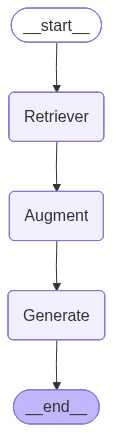

In [25]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from IPython.display import Image, display

# === Define workflow node functions ===
def retrieve_context(state):
    """Retrieve top documents from ChromaDB based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message
    query_embedding = generate_embedding(query)
    results = collection1.query(
        #query_texts=[query],
        query_embeddings=[query_embedding],
        n_results=3
        )
    context = "\n".join(results["documents"][0])

    #state["query"] = query
    state["context"] = context
    print(context)
    # Save context in the state for later nodes
    return state

def build_prompt(state):
    """Construct the RAG-style prompt."""
    print("---AUGMENT (BUILDING PROMPT)---")
    query = state["query"]
    context = state["context"]

    prompt = f"""
            Responda a seguinte pergunta usando, APENAS, o contexto fornecido abaixo.
            Sempre responda em português brasileiro (pt-br).
            Não use outras fontes além do contexto fornecido.
            Se o usuário perguntar sobre outro assunto (fora do contexto fornecido),
            responda: "A sua pergunta está fora do contexto que foi fornecido para mim."

            Contexto:
            {context}

            Pergunta: {query}

            Por favor, limite sua resposta em 50 palavras.
            """
    
    state["prompt"] = prompt
    print(prompt)
    return state

def call_llm(state):
    """Chama a função do LLM existente."""
    print("---GENERATE (CALLING LLM)---")
    prompt = state["prompt"]
    answer = get_llm_response(prompt)
    state["response"] = answer
    return state

# === Build the workflow ===

## Define o estado da estrutura:
class GraphState(TypedDict):
    query : str
    prompt : str
    context : List[str]
    response : str

    
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("Retriever", retrieve_context)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", call_llm)

# Define edges
workflow.add_edge(START, "Retriever")
workflow.add_edge("Retriever", "Augment")
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)

# Compile agent
rag_agent = workflow.compile()

# === Run it ===
display(Image(rag_agent.get_graph().draw_mermaid_png()))


In [26]:
from pprint import pprint

input_state = {"query": "Que pessoas podem desenvolver a doença coriomeningite linfocítica (LCM)?" #"Quais são os tratamentos para a doença de Kawasaki?"
              }


for step in rag_agent.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")


---RETRIEVING CONTEXT---
Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?. Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.. Type: susceptibility. 
Question: What are the treatments for Lymphocytic Choriomeningitis (LCM) ?. Answer: Aseptic meningitis, encephalitis, or meningoencephalitis requires hospitalization and supportive treatment based on severity. Anti-inflammatory drugs, such as corticosteroids, may be considered under specific circumstances. Although studies have shown that ribavirin, a drug used to treat several other viral diseases, is e

In [27]:
pprint(value["response"])

('As pessoas em risco são aquelas expostas a urina fresca, fezes, saliva ou '
 'materiais de nidificação de roedores infectados. A transmissão pode ocorrer '
 'quando esses materiais entram na pele ferida, no nariz, nos olhos ou na '
 'boca, ou, presumivelmente, por mordida de roedor. Transmissão '
 'pessoa-a-pessoa é rara (vertical, transplante).')


In [29]:
from pprint import pprint

input_state = {"query": "Quem foi Pelé?" #"Quais são os tratamentos para a doença de Kawasaki?"
              }


for step in rag_agent.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")



pprint(value["response"])

---RETRIEVING CONTEXT---
Question: What is (are) Parasites - Cysticercosis ?. Answer: Cysticercosis is an infection caused by the larvae of the parasite Taenia solium.  This infection occurs after a person swallows tapeworm eggs. The larvae get into tissues such as muscle and brain, and form cysts there (these are called cysticerci). When cysts are found in the brain, the condition is called neurocysticercosis.. Type: information. 
Question: Who is at risk for Parasites - Cysticercosis? ?. Answer: Cysticercosis is an infection caused by the larvae of the tapeworm, Taenia solium. A person with an adult tapeworm, which lives in the person’s gut, sheds eggs in the stool.  The infection with the adult tapeworm is called taeniasis.  A pig then eats the eggs in the stool.  The eggs develop into larvae inside the pig and form cysts (called cysticerci) in the pig's muscles or other tissues. The infection with the cysts is called cysticercosis. Humans who eat undercooked or raw infected pork sw

# <font color="yellow">``Parte B:``Agente RAG</font>

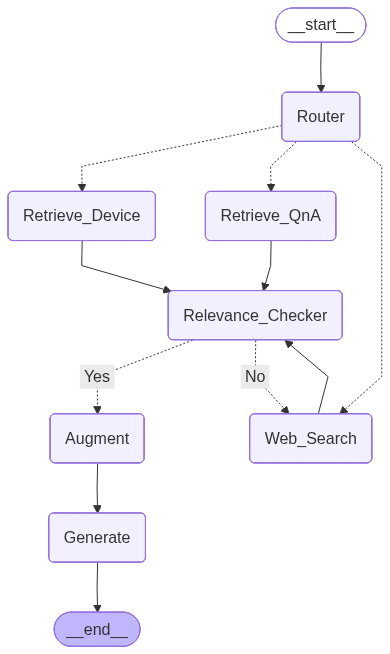

In [33]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import List
from IPython.display import Image, display


# === Define workflow node functions ===
def retrieve_context_q_n_a(state):
    """Retrieve top documents from ChromaDB Collection 1 (Medical Q&A Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message
    query_embedding = generate_embedding(query)
    
    results = collection1.query(
        #query_texts=[query],
        query_embeddings=[query_embedding],
        n_results=3
    )
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Q&A Collection"
    print(context)
    # Save context in the state for later nodes
    return state

# === Define workflow node functions ===
def retrieve_context_medical_device(state):
    """Retrieve top documents from ChromaDB Collection 2 (Medical Device Manuals Data) based on query."""
    print("---RETRIEVING CONTEXT---")
    query = state["query"] # last user message
    query_embedding = generate_embedding(query)

    results = collection2.query(
        #query_texts=[query],
        query_embeddings=[query_embedding],
        n_results=3
    )
    context = "\n".join(results["documents"][0])
    state["context"] = context
    state["source"] = "Medical Device Manual"
    print(context)
    # Save context in the state for later nodes
    return state

def web_search(state):
    """Perform web search using Google Serper API."""
    print("---PERFORMING WEB SEARCH---")
    query = state["query"]
    search_results = search.run(query=query)
    state["context"] = search_results
    state["source"] = "Web Search"
    print(search_results)
    return state

def router(state: GraphState) -> Literal[
    "Retrieve_QnA", "Retrieve_Device", "Web_Search"
]:
    """Agentic router: decides which retrieval method to use."""
    query = state["query"]

    # A lightweight decision LLM — you can replace this with GPT-4o-mini, etc.
    decision_prompt = f"""
    Você é um agente de roteamento. Baseado na consulta/pergunta do usuário, você 
    deverá decidir onde buscar informações.

    Opções:
    - Retrieve_QnA: se a consulta/pergunta é sobre conhecimento médico geral,
      sintomas ou tratamentos.
    - Retrieve_Device: se a consulta/pergunta é sobre dispositivos médicos,
      manuais ou instruções.
    - Web_Search: se a consulta/pergunta é sobre notícias recentes, marcas ou
      dados externos.

    Pergunta: "{query}"

    Responda APENAS com uma das opções: Retrieve_QnA, Retrieve_Device, Web_Search
    """

    router_decision = get_llm_response(decision_prompt).strip()
    print(f"---ROUTER DECISION: {router_decision}---")

    print(router_decision)

    state["source"] = router_decision
    return state

# Define a função de roteamento para o edge condicional
def route_decision(state: GraphState) -> str:
    return state["source"]


def build_prompt(state):
    """Construe o PROMPT no estilo RAG."""
    print("---AUGMENT (BUILDING GENERATIVE PROMPT)---")
    query = state["query"]
    context = state["context"]

    prompt = f"""
            Responda a seguinte pergunta usando, APENAS, o contexto fornecido abaixo.
            Sempre responda em português brasileiro (pt-br).

            Contexto:
            {context}
            
            Pergunta: {query}
            Por favor, limite sua resposta em 50 palavras.
            """
    
    state["prompt"] = prompt
    print(prompt)
    return state


def call_llm(state):
    """Call your existing LLM function."""
    print("---GENERATE (CALLING LLM)---")
    prompt = state["prompt"]
    answer = get_llm_response(prompt)
    state["response"] = answer
    return state


def check_context_relevance(state):
    """Determine whether to retrieved context is relevant or not."""
    print("---CONTEXT RELEVANCE CHECKER---")
    query = state["query"]
    context = state["context"]

    relevance_prompt = f"""
            Verifique se o contexto (delimitado por ####) fornecido é relevante
            à consulta/pergunta do usuário.
            
            ####
            Contexto:
            {context}
            ####
            
            Pergunta do usuário: {query}

            Opções:
            - Sim/Yes: se o contexto é relevante.
            - Não/No: se o contexto não é relevante.

            Responda APENAS com 'Sim' ou 'Não'.
            """
    relevance_decision_value = get_llm_response(relevance_prompt).strip()

    # Normalizar para Inglês:
    if relevance_decision_value.lower() in ["sim", "yes", "s", "y"]:
        relevance_decision_value = "Yes"
    elif relevance_decision_value.lower() in ["não", "nao", "no", "n"]:
        relevance_decision_value = "No"
    else:
        print(f"Resposta inesperada: {relevance_decision_value}, assumindo 'Yes'")
        relevance_decision_value = "Yes"

    print(f"---RELEVANCE DECISION: {relevance_decision_value}---")
    state["is_relevant"] = relevance_decision_value
    return state

# Define the check_context_relevance function for the conditional edge
def relevance_decision(state: GraphState) -> str:
    iteration_count = state.get("iteration_count", 0)
    iteration_count += 1
    state["iteration_count"] = iteration_count
    ## Limiting to max 3 iterations
    if iteration_count >= 3:
        print("---MAX ITERATIONS REACHED, FORCING 'Sim'---")
        state["is_relevant"] = "Yes"
    return state["is_relevant"]





# === Build the workflow ===
## Define the state structure

class GraphState(TypedDict):
    query: str
    context: str
    prompt: str
    response: str
    source: str  # Which retriever/tool was used
    is_relevant: str
    iteration_count: int

    
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("Router", router)
workflow.add_node("Retrieve_QnA", retrieve_context_q_n_a)
workflow.add_node("Retrieve_Device", retrieve_context_medical_device)
workflow.add_node("Web_Search", web_search)
workflow.add_node("Relevance_Checker", check_context_relevance)
workflow.add_node("Augment", build_prompt)
workflow.add_node("Generate", call_llm)

# Define edges
workflow.add_edge(START, "Router")
workflow.add_conditional_edges(
    "Router",
    route_decision,  # this function decides the path dynamically
    {
        "Retrieve_QnA": "Retrieve_QnA",
        "Retrieve_Device": "Retrieve_Device",
        "Web_Search": "Web_Search",
    }
)
workflow.add_edge("Retrieve_QnA", "Relevance_Checker")
workflow.add_edge("Retrieve_Device", "Relevance_Checker")
workflow.add_edge("Web_Search", "Relevance_Checker")
workflow.add_conditional_edges(
    "Relevance_Checker",
    relevance_decision,  # this function decides the path dynamically
    {
        "Yes": "Augment",
        "No": "Web_Search",
    }
)
workflow.add_edge("Augment", "Generate")
workflow.add_edge("Generate", END)


# Compile the dynamic RAG agent
agentic_rag = workflow.compile()


# ===================================
# ===  Visualize Workflow (Optional) ===
# ===================================


# === Run it ===
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [34]:
from pprint import pprint


input_state = {"query":"Que pessoas podem desenvolver a doença coriomeningite linfocítica (LCM)?"  #"Quais são os tratamentos para a doença de Kawasaki?"
              }

for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")


---ROUTER DECISION: Retrieve_QnA---
Retrieve_QnA
'Finished running: Router:'
---RETRIEVING CONTEXT---
Question: Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?. Answer: LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.. Type: susceptibility. 
Question: What are the treatments for Lymphocytic Choriomeningitis (LCM) ?. Answer: Aseptic meningitis, encephalitis, or meningoencephalitis requires hospitalization and supportive treatment based on severity. Anti-inflammatory drugs, such as corticosteroids, may be considered under specific circumstances. Although studies have 

In [35]:
pprint(value["response"])

('Pessoas expostas a urina, fezes, saliva ou materiais de ninho de roedores '
 'infectados. A transmissão entre pessoas não ocorre, exceto de mãe para feto '
 'durante a gravidez e, raramente, por transplante de órgãos.')


In [36]:
from pprint import pprint


input_state = {"query": "Quais são as indicações de uso do dispositivo para diálise?"}

for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")

---ROUTER DECISION: Retrieve_Device---
Retrieve_Device
'Finished running: Router:'
---RETRIEVING CONTEXT---
Device Name: Dialysis Machine. Model: Model 7456. Manufacturer: Thermo Fisher Scientific. Indications: Used for electrotherapy guidance in oncology treatment centers for cancer patients.. Contraindications: Not suitable for use during electromagnetic therapy or X-ray.
Device Name: Insulin Pump. Model: SIE362. Manufacturer: Siemens Healthineers. Indications: Designed for defibrillation support in neonatal intensive care environments.. Contraindications: Contraindicated in patients with severe anemia or unable to follow instructions.
Device Name: Defibrillator. Model: B. 342. Manufacturer: B. Braun. Indications: Used for intraoperative infection prevention monitoring during complex ophthalmic surgeries.. Contraindications: Avoid use in patients with severe cardiac arrhythmias or severe severe osteoporosis.
'Finished running: Retrieve_Device:'
---CONTEXT RELEVANCE CHECKER---
---RELE

In [37]:
pprint(value["response"])

('Para a diálise (hemodiálise), a indicação é para pacientes com insuficiência '
 'renal aguda ou crônica graves. A decisão de iniciar o tratamento é feita '
 'pelo médico, com base na avaliação clínica e nos exames laboratoriais.')


In [38]:
from pprint import pprint

input_state = {"query": "Qual é a alíquota de exportação de medicamentos na Índia em 2025?"}

for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")


---ROUTER DECISION: Web_Search---
Web_Search
'Finished running: Router:'
---PERFORMING WEB SEARCH---
“A partir de 1º de outubro de 2025, estaremos impondo uma tarifa de 100% sobre qualquer produto farmacêutico de marca ou patenteado, a menos que ... Missing: alíquota exportação. Despite the U.S. imposing 100% tariffs on Indian pharmaceutical drugs, India's pharma exports are set to surge past $30 billion in 2025, ... Missing: alíquota exportação medicamentos. As vendas no país aumentaram 20%, para aproximadamente US$ 10,5 bilhões no ano fiscal de 2025. "A Índia quer aumentar as exportações para outros ... Missing: alíquota | Show results with:alíquota. Medicamentos são isentos de tarifas. Se a Índia parar as exportações de remédios para os EUA, é suicídio para as empresas farmacêuticas locais. Missing: alíquota | Show results with:alíquota. A indústria farmacêutica da Índia está atualmente isenta das tarifas de até 50% impostas pelo presidente dos Estados Unidos, Donald Trump, mas o ..

In [40]:
pprint(value["response"])

'A alíquota de exportação de medicamentos na Índia em 2025 é de 15%.'


In [41]:
from pprint import pprint

input_state = {"query": "Quais são os medicamentos/tratamentos para a COVID?"}


for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")


pprint(value["response"])

---ROUTER DECISION: Retrieve_QnA---
Retrieve_QnA
'Finished running: Router:'
---RETRIEVING CONTEXT---
Question: how can these diseases be treated for Marine Toxins ?. Answer: Other than supportive care there are few specific treatments for ciguatera poisoning, paralytic shellfish poisoning, neurotoxic shellfish poisoning, or amnesic shellfish poisoning. Antihistamines and epinephrine, however, may sometimes be useful in treating the symptoms of scombrotoxic fish poisoning. Intravenous mannitol has been suggested for the treatment of severe ciguatera poisoning.. Type: treatment. 
Question: What are the treatments for Lymphocytic Choriomeningitis (LCM) ?. Answer: Aseptic meningitis, encephalitis, or meningoencephalitis requires hospitalization and supportive treatment based on severity. Anti-inflammatory drugs, such as corticosteroids, may be considered under specific circumstances. Although studies have shown that ribavirin, a drug used to treat several other viral diseases, is effectiv

In [43]:
from pprint import pprint

input_state = {"query": "Onde nasceu Eddy Giusepe Chirinos Isidro?"}


for step in agentic_rag.stream(input_state):
    for key, value in step.items():
        pprint(f"Finished running: {key}:")


pprint(value["response"])

---ROUTER DECISION: Web_Search---
Web_Search
'Finished running: Router:'
---PERFORMING WEB SEARCH---
As a data scientist at VIXPar, I will work with large volumes of data from logistics, fleet management, and urban mobility operations. Missing: nasceu | Show results with:nasceu. No início da crise, muitos engenheiros, contadores e gerentes, ficaram desempregados e foram obrigados a fazer bico de motorista de aplicativo para... Eddy Giusepe Chirinos isidro. 6,38. 4,40. 5,99. 2. Márcio. Kayodê David de Melo Souza. 5,44. 0,00. 4,35. 3. Wellington. CANDIDATO. ETAPA 1 ETAPA 2 NOTA FINAL. 14, Eddy Giusepe Chirinos Isidro, UFES ; 15, Felipe de Melo Santos, UFES ; 16, Felipe Tovar Falciano, CBPF ; 17, Guilherme Brando De Oliveira, UFES. Eddy Giusepe Chirinos Isidro. Edher de Souza Ferreira de Miranda. Eliane Quintiliano Nascimento. Isabela Ariane Bujato. Layziane Souza Silva. Leonardo Aranha ... Control Number. Requester Name. Trk Scanned. Created. Subject. BLR2015000038. Appel, Edward. 1. 10/